# Load library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

from sklearn import metrics


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load dataset

In [3]:
url = 'https://raw.githubusercontent.com/Jessadakorn-pun/Dataset/main/HousingData.csv'
df = pd.read_csv(url)
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,NaN,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,NaN,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


In [9]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
df['LSTAT'] = imp.fit_transform(df[['LSTAT']])

In [23]:
X = df[['LSTAT']]
y = df['MEDV']

# Split data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=1)

In [26]:
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')

X_train.shape = (354, 1)
X_test.shape = (152, 1)


# Fitting Ransac with linear regression

In [170]:
def train(rc, X_train, y_train, X_test, y_test, model_name, cols):
    ## fitting model
    rc.fit(X_train, y_train)
    model = rc.estimator_
    coef = model.coef_
    inter = model.intercept_ 
    
    ## predict
    y_train_pred = rc.predict(X_train)
    y_test_pred = rc.predict(X_test)
    
    ## score
    mse_tr = metrics.mean_squared_error(y_train, y_train_pred)
    mse_te = metrics.mean_squared_error(y_test, y_test_pred)
    r2_tr = metrics.r2_score(y_train, y_train_pred)
    r2_te = metrics.r2_score(y_test, y_test_pred)
    
    ## cols = ['model name', 'Coef', 'Intercept', 'MSE Train', 'MSE Test', 'R2 Train', 'R2 Test']
    collect = [model_name, coef, inter, mse_tr, mse_te, r2_tr, r2_te]
    
    ## ploting result
    inliner_mask = rc.inlier_mask_
    outliner_mask = np.logical_not(inliner_mask)
    
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    ax[0].plot(X_train, y_train_pred, color = 'black', lw = 2)
    ax[0].scatter(X_train, y_train, c = 'green', alpha = .5)
    ax[0].set_title(f'Train Data : {model_name}')
    ax[0].scatter(X_train[inliner_mask], y_train[inliner_mask], color = 'orange', edgecolors = 'black', alpha=.5)
    
    ax[1].plot(X_test, y_test_pred, color = 'black', lw = 2)
    ax[1].scatter(X_test, y_test, c = 'blue', alpha = .5)
    ax[1].set_title(f'Test Data : {model_name}')
    #ax[1].scatter(X_test[inliner_mask], y_test[inliner_mask], color = 'red', alpha=.5)
    
    
    
    return collect
    

,model name,Coef,Intercept,MSE Train,MSE Test,R2 Train,R2 Test
0,Ransac-1,-0.641168,28.926522,45.630650,53.113655,0.437970,0.420501
1,Ransac-5,-0.753453,30.180953,43.928087,49.899158,0.458941,0.455573
2,Ransac-10,-0.769848,31.126137,41.378421,47.349139,0.490345,0.483395
3,Ransac-15,-0.926257,34.033573,39.028665,43.444464,0.519287,0.525997
4,Ransac-20,-0.899054,33.802902,38.960033,43.785279,0.520132,0.522279


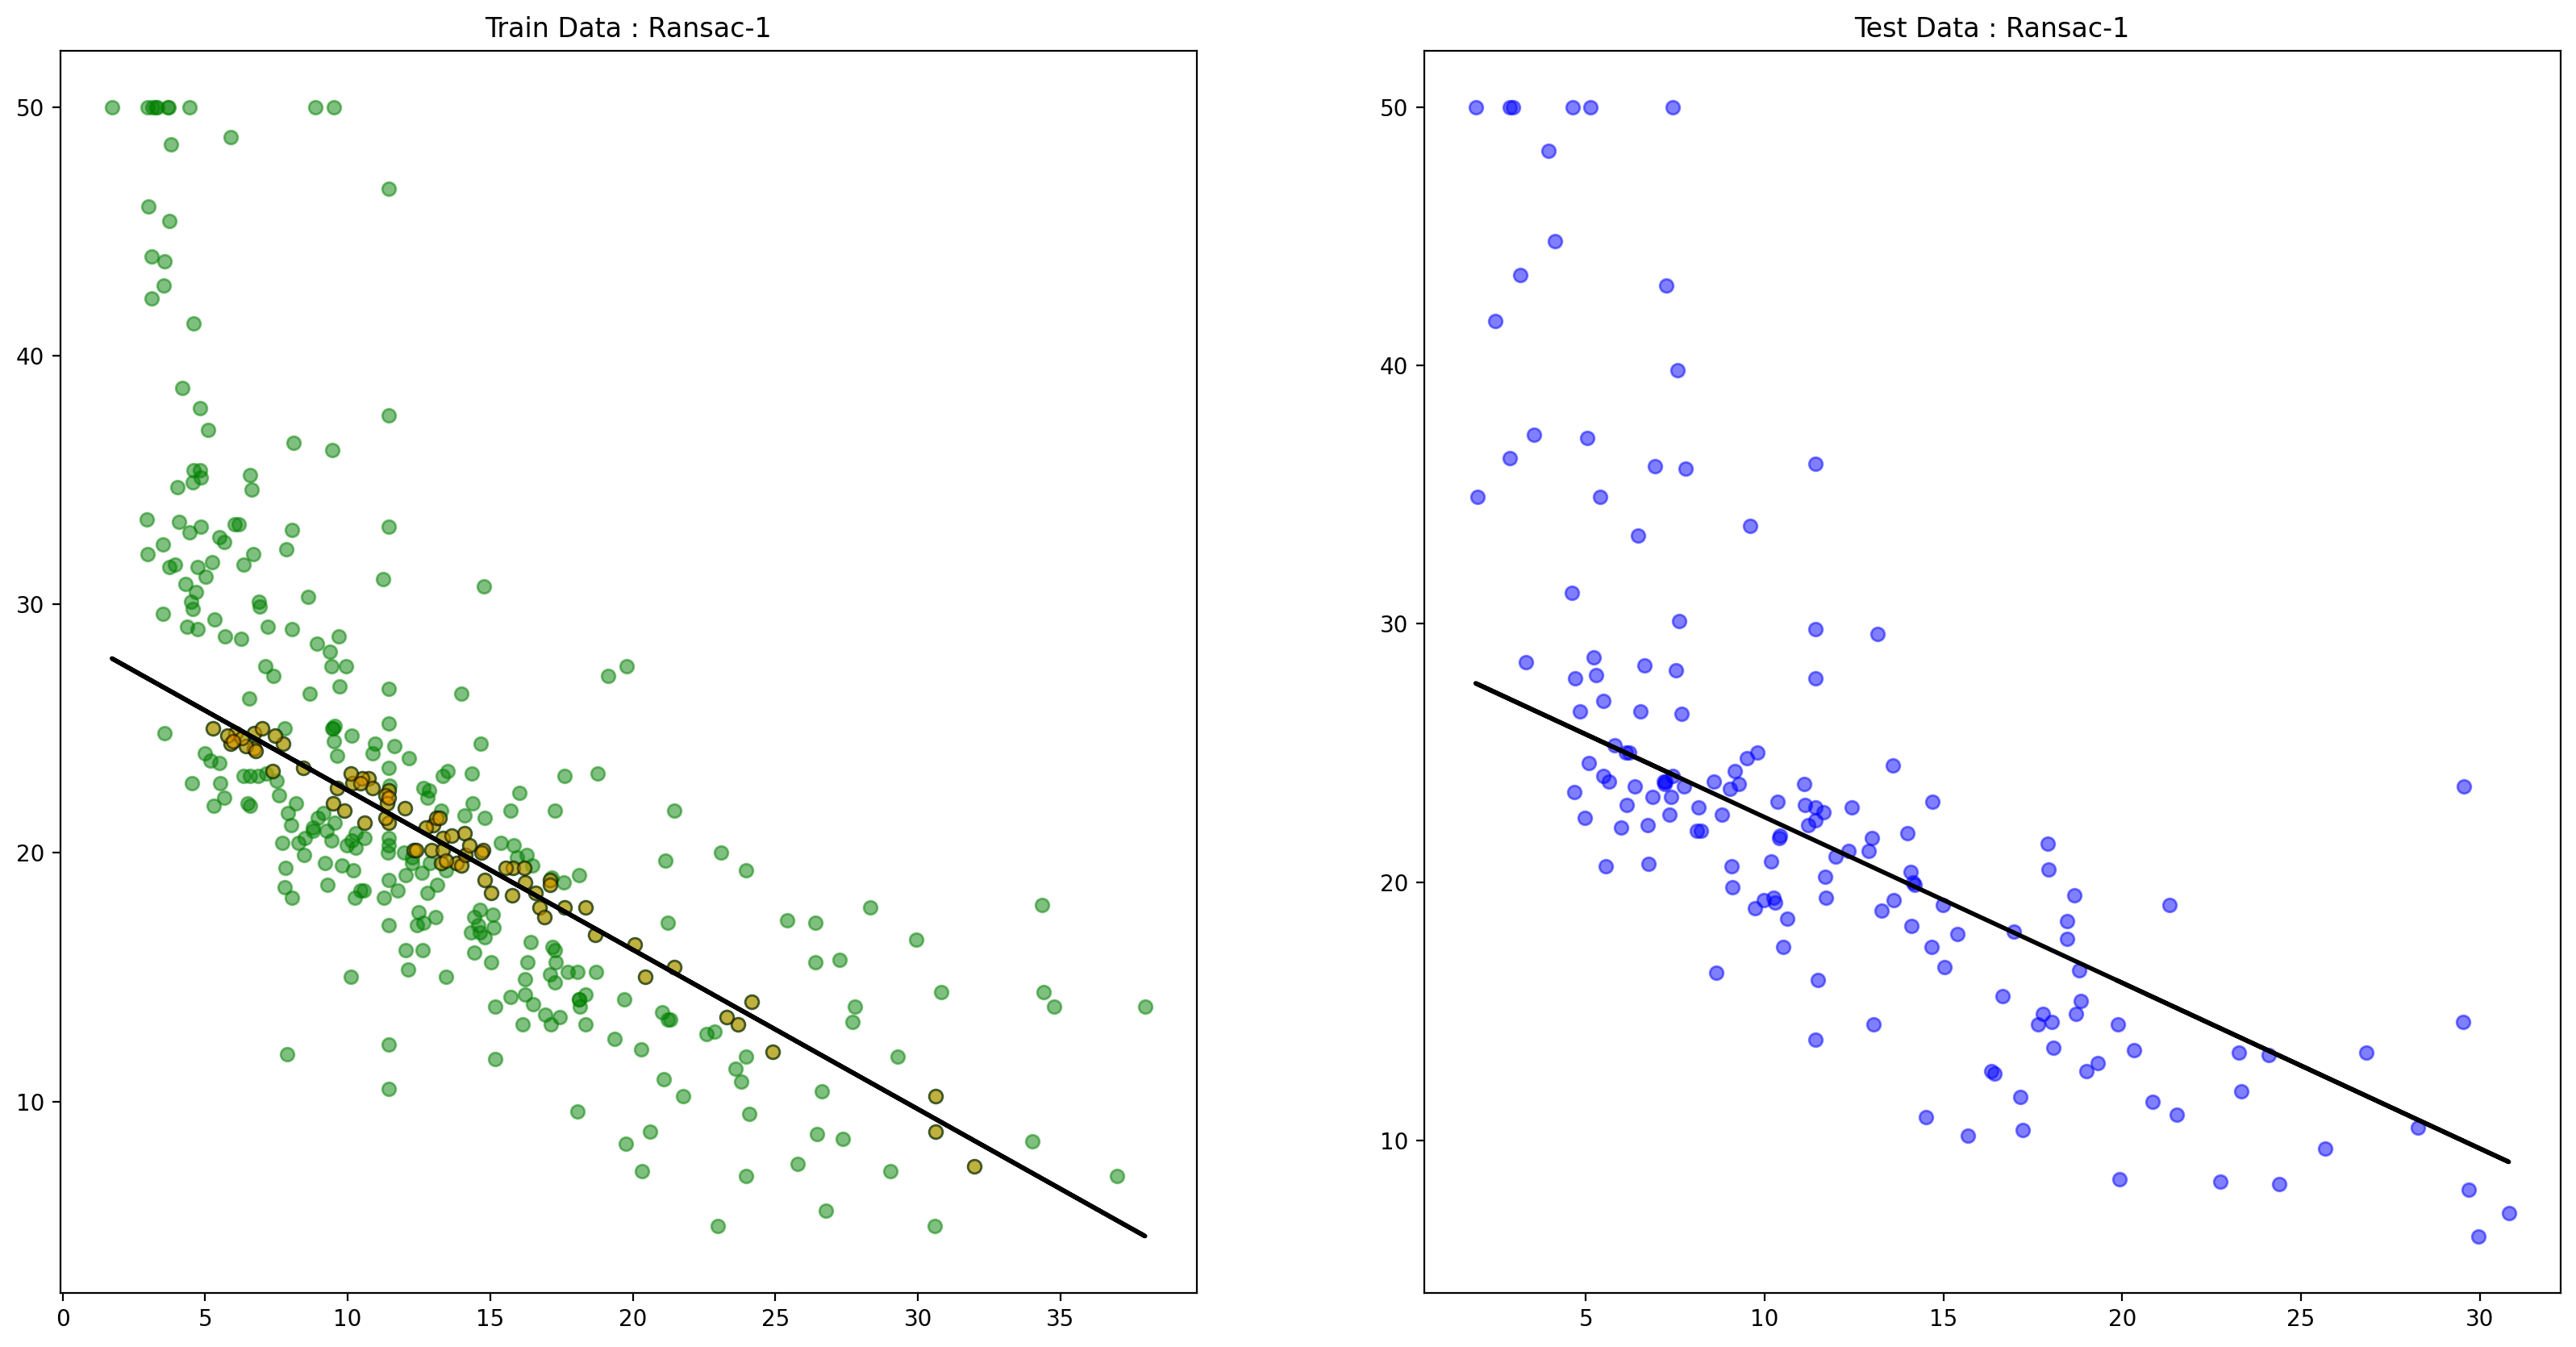

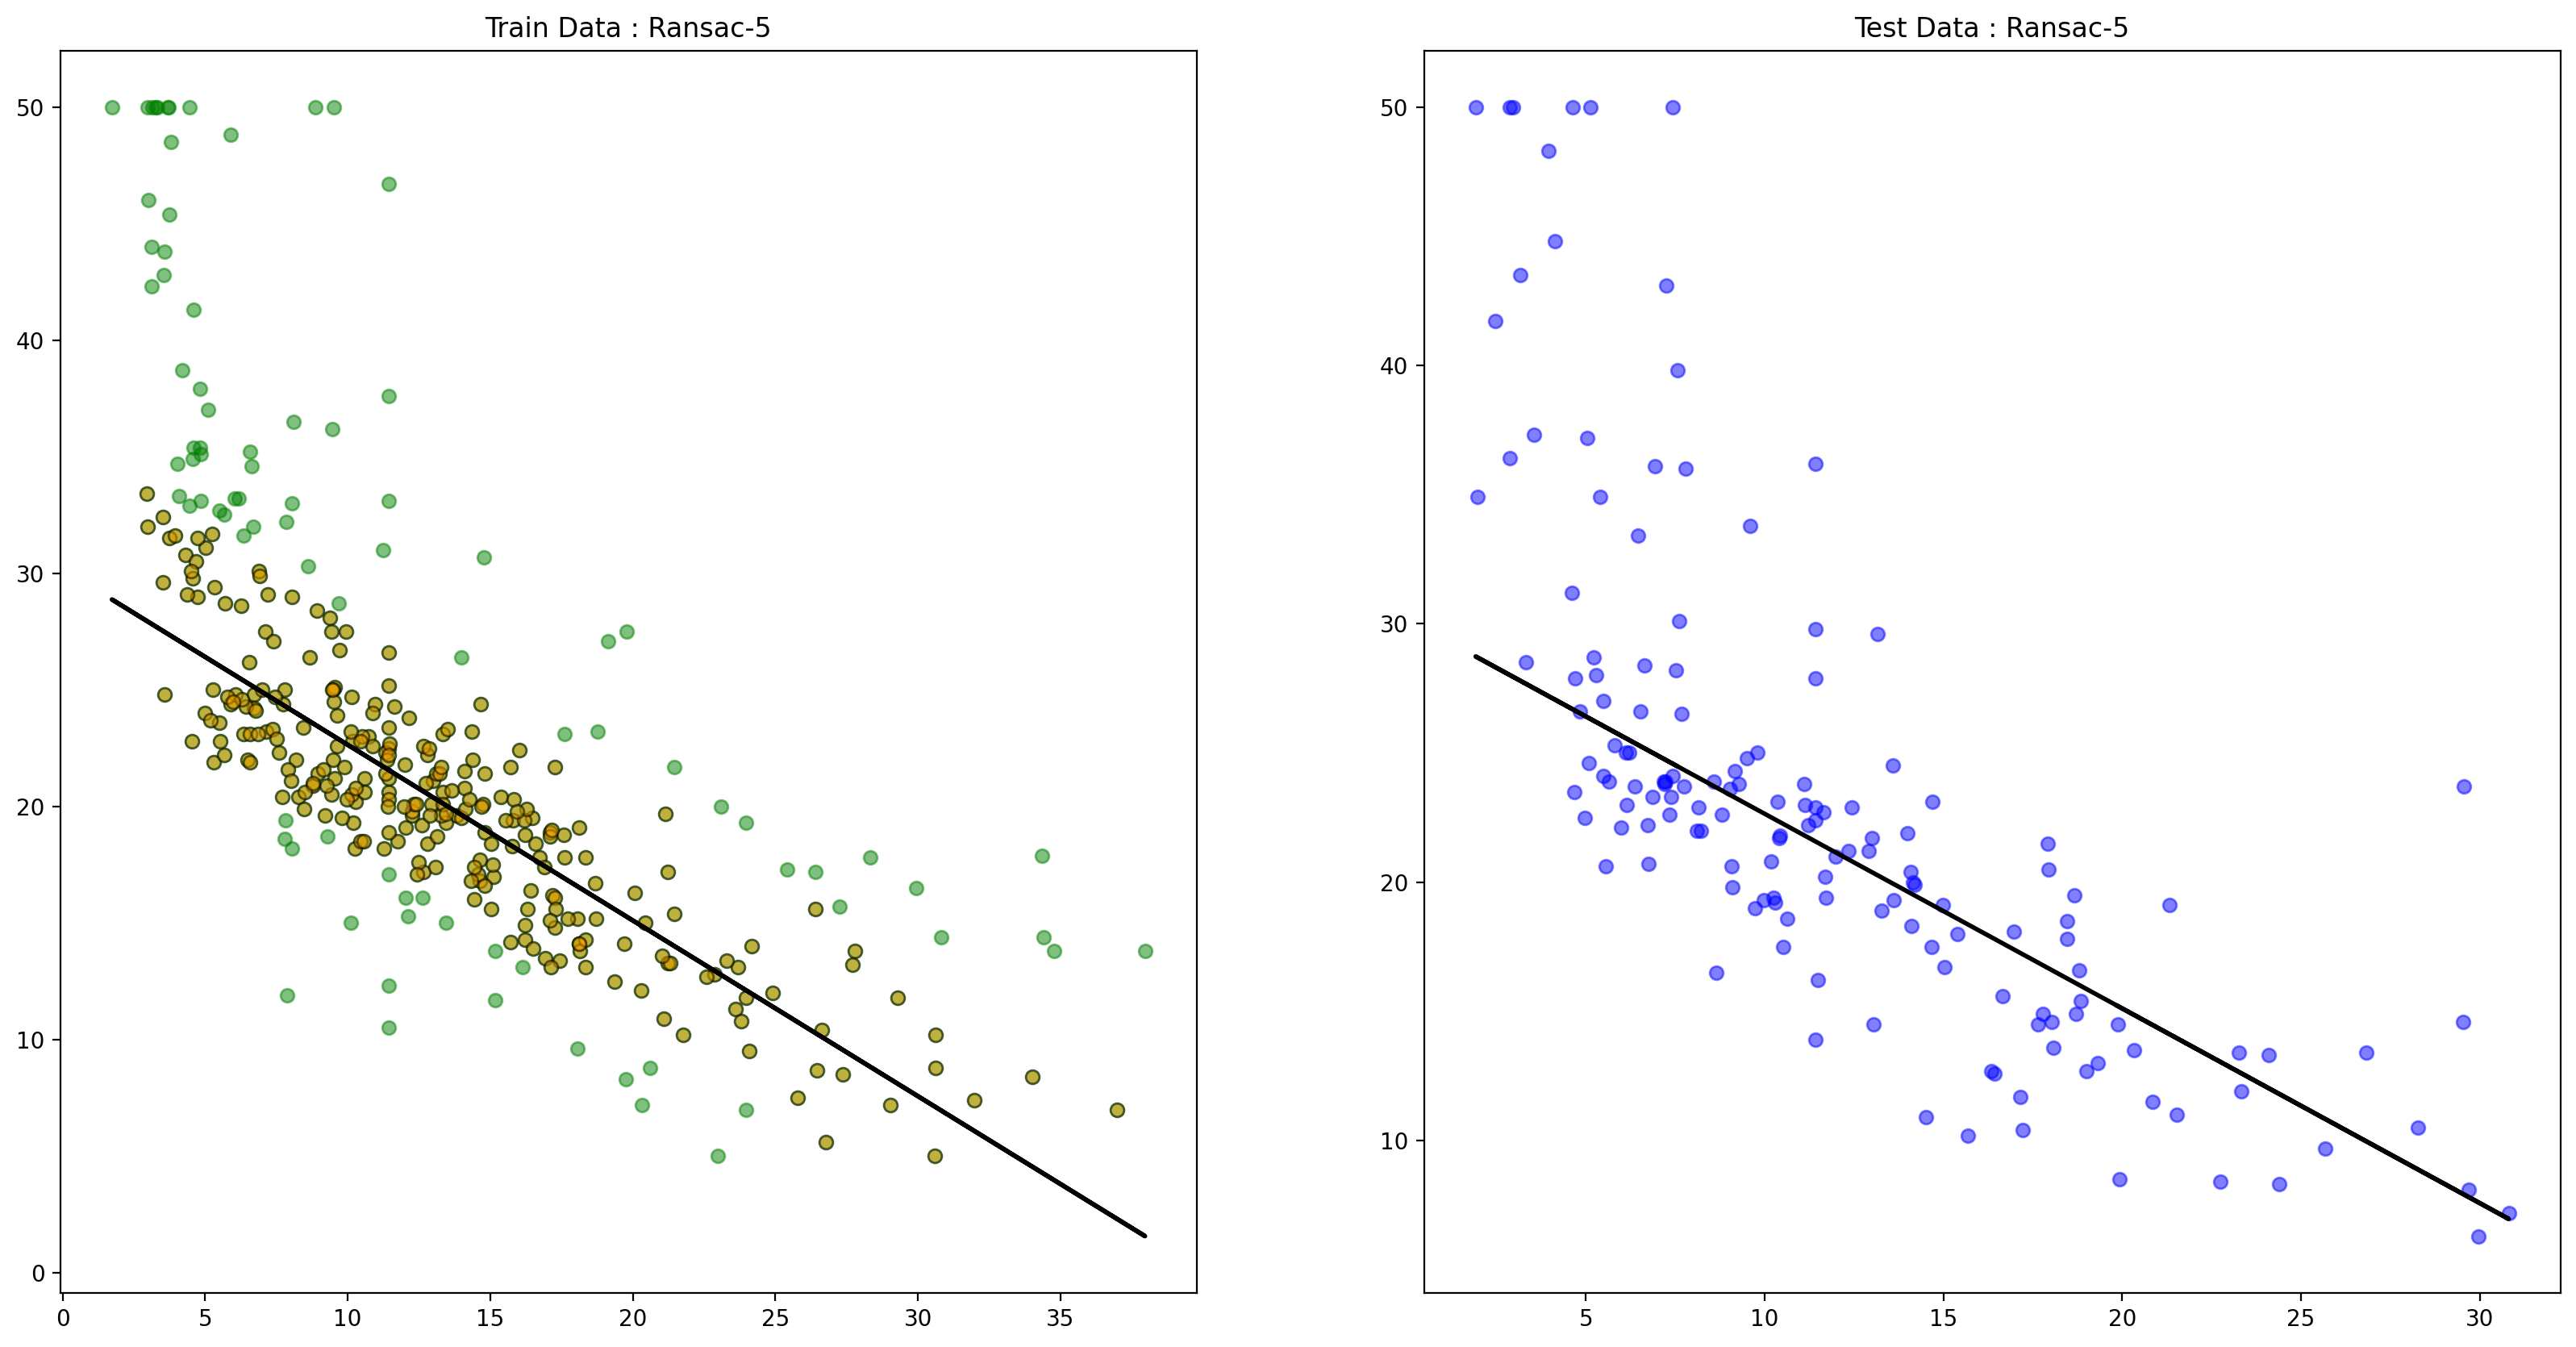

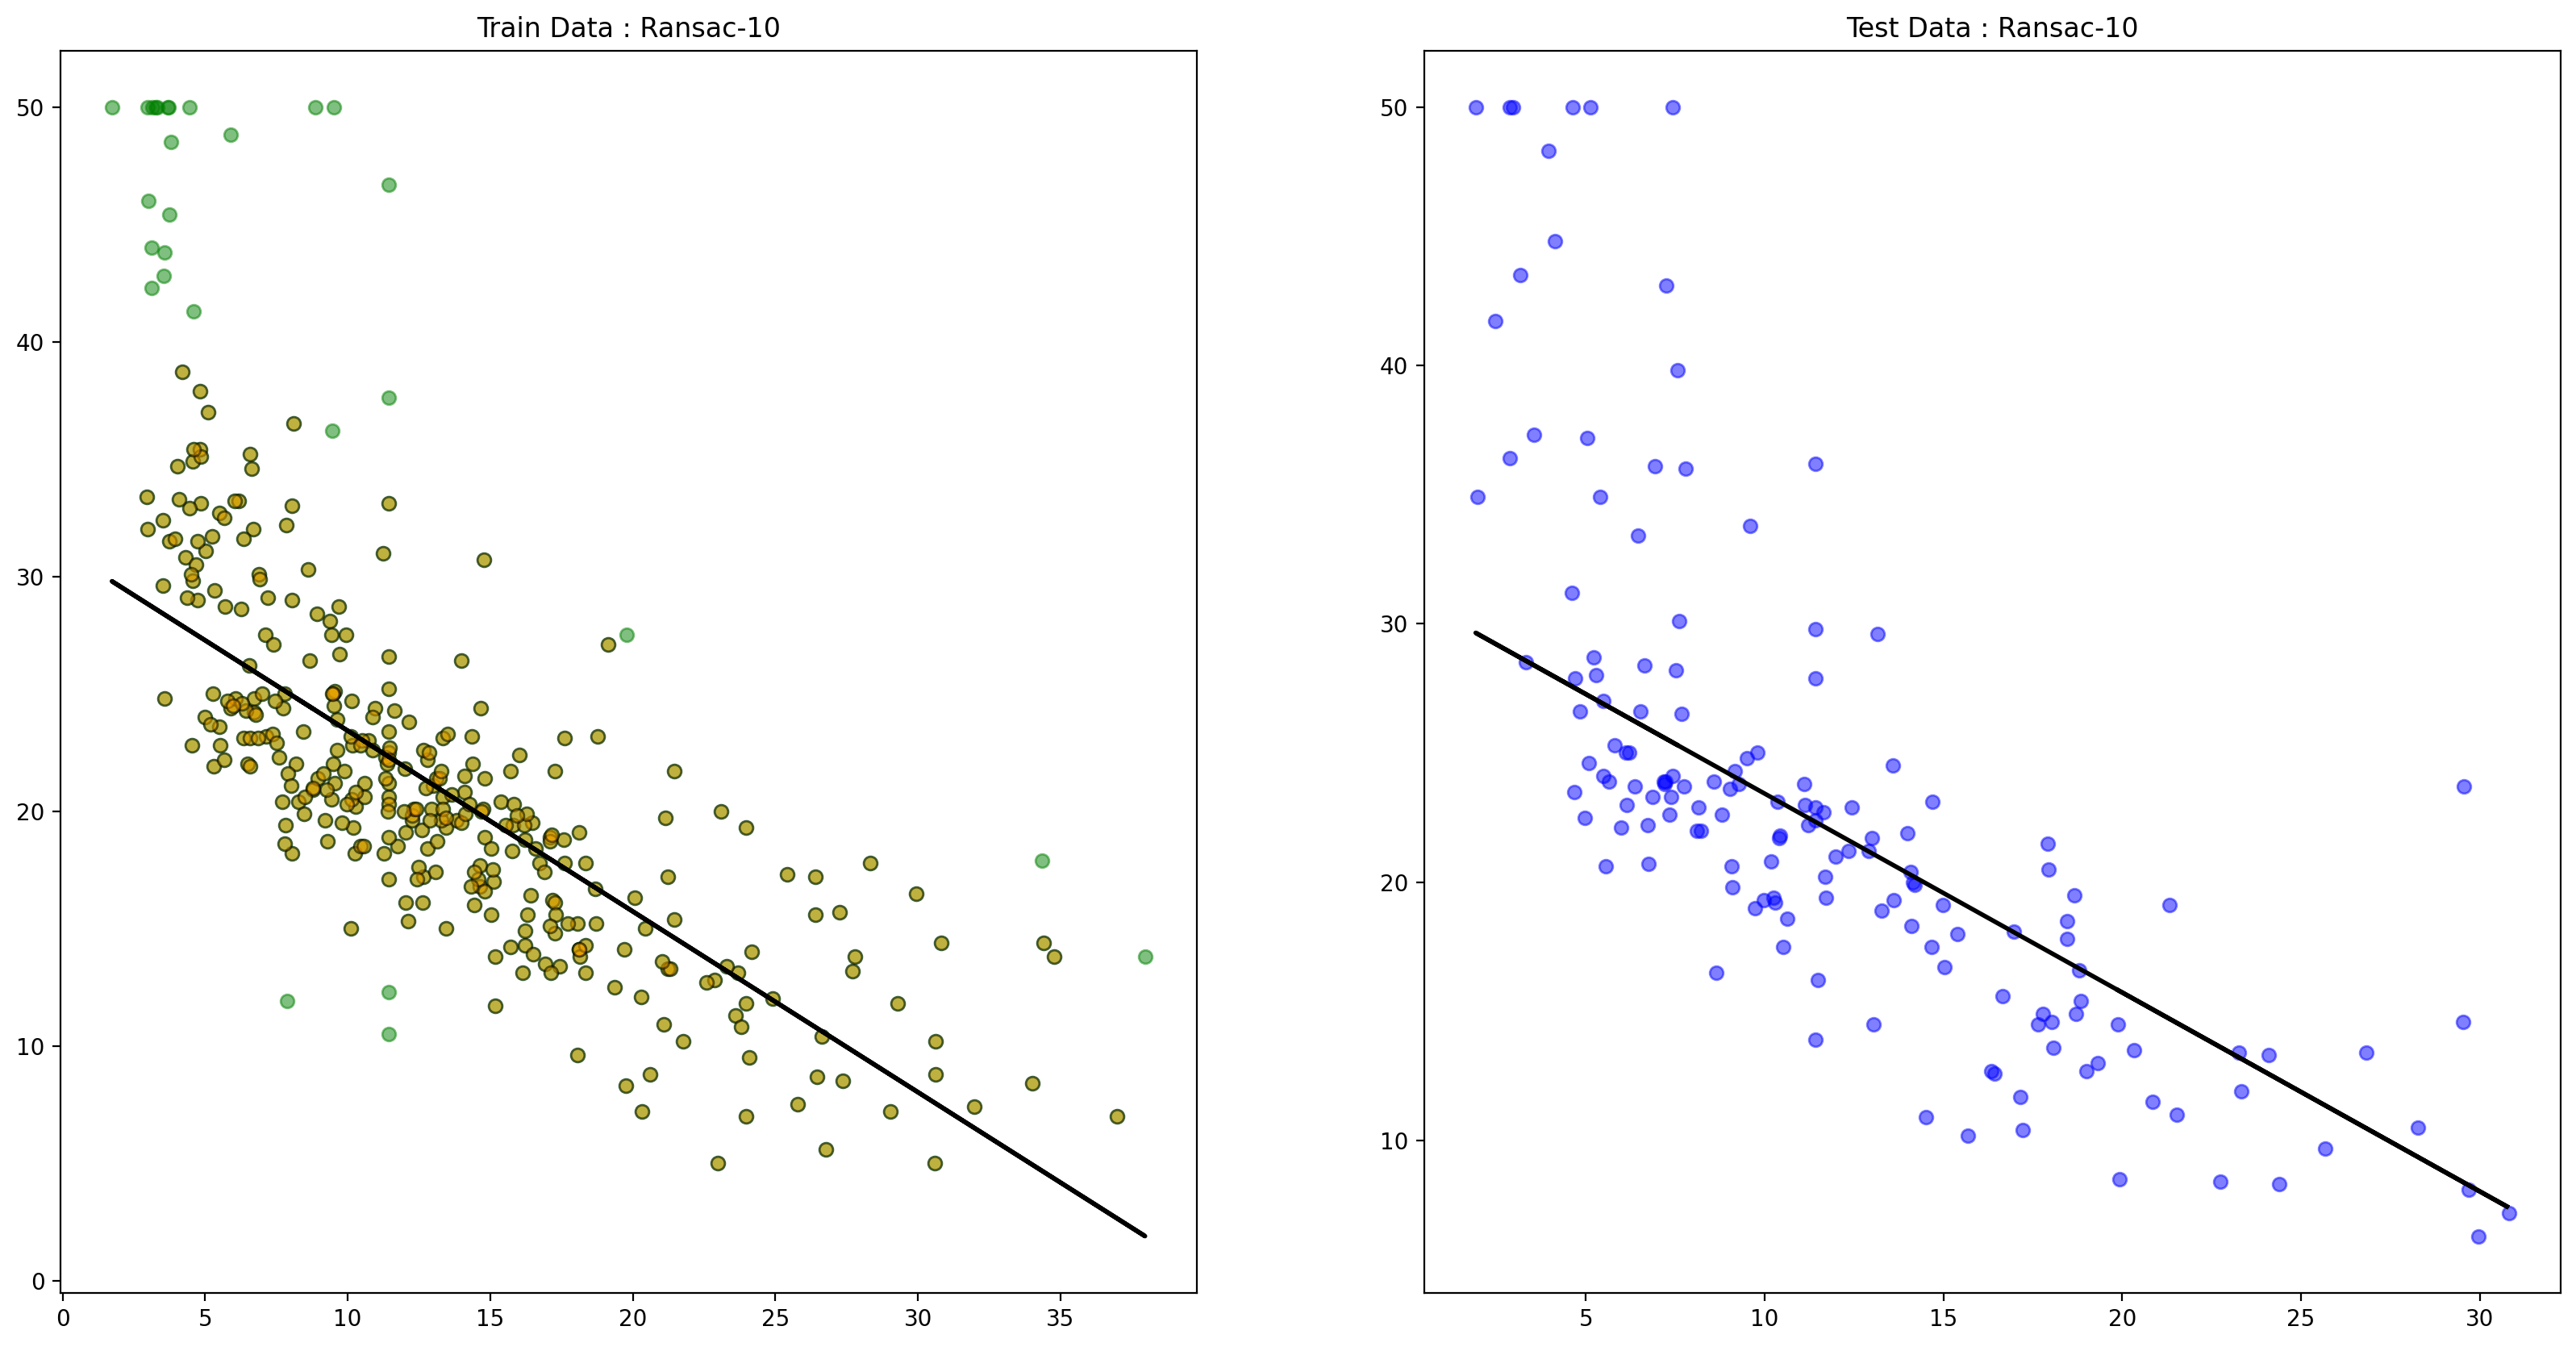

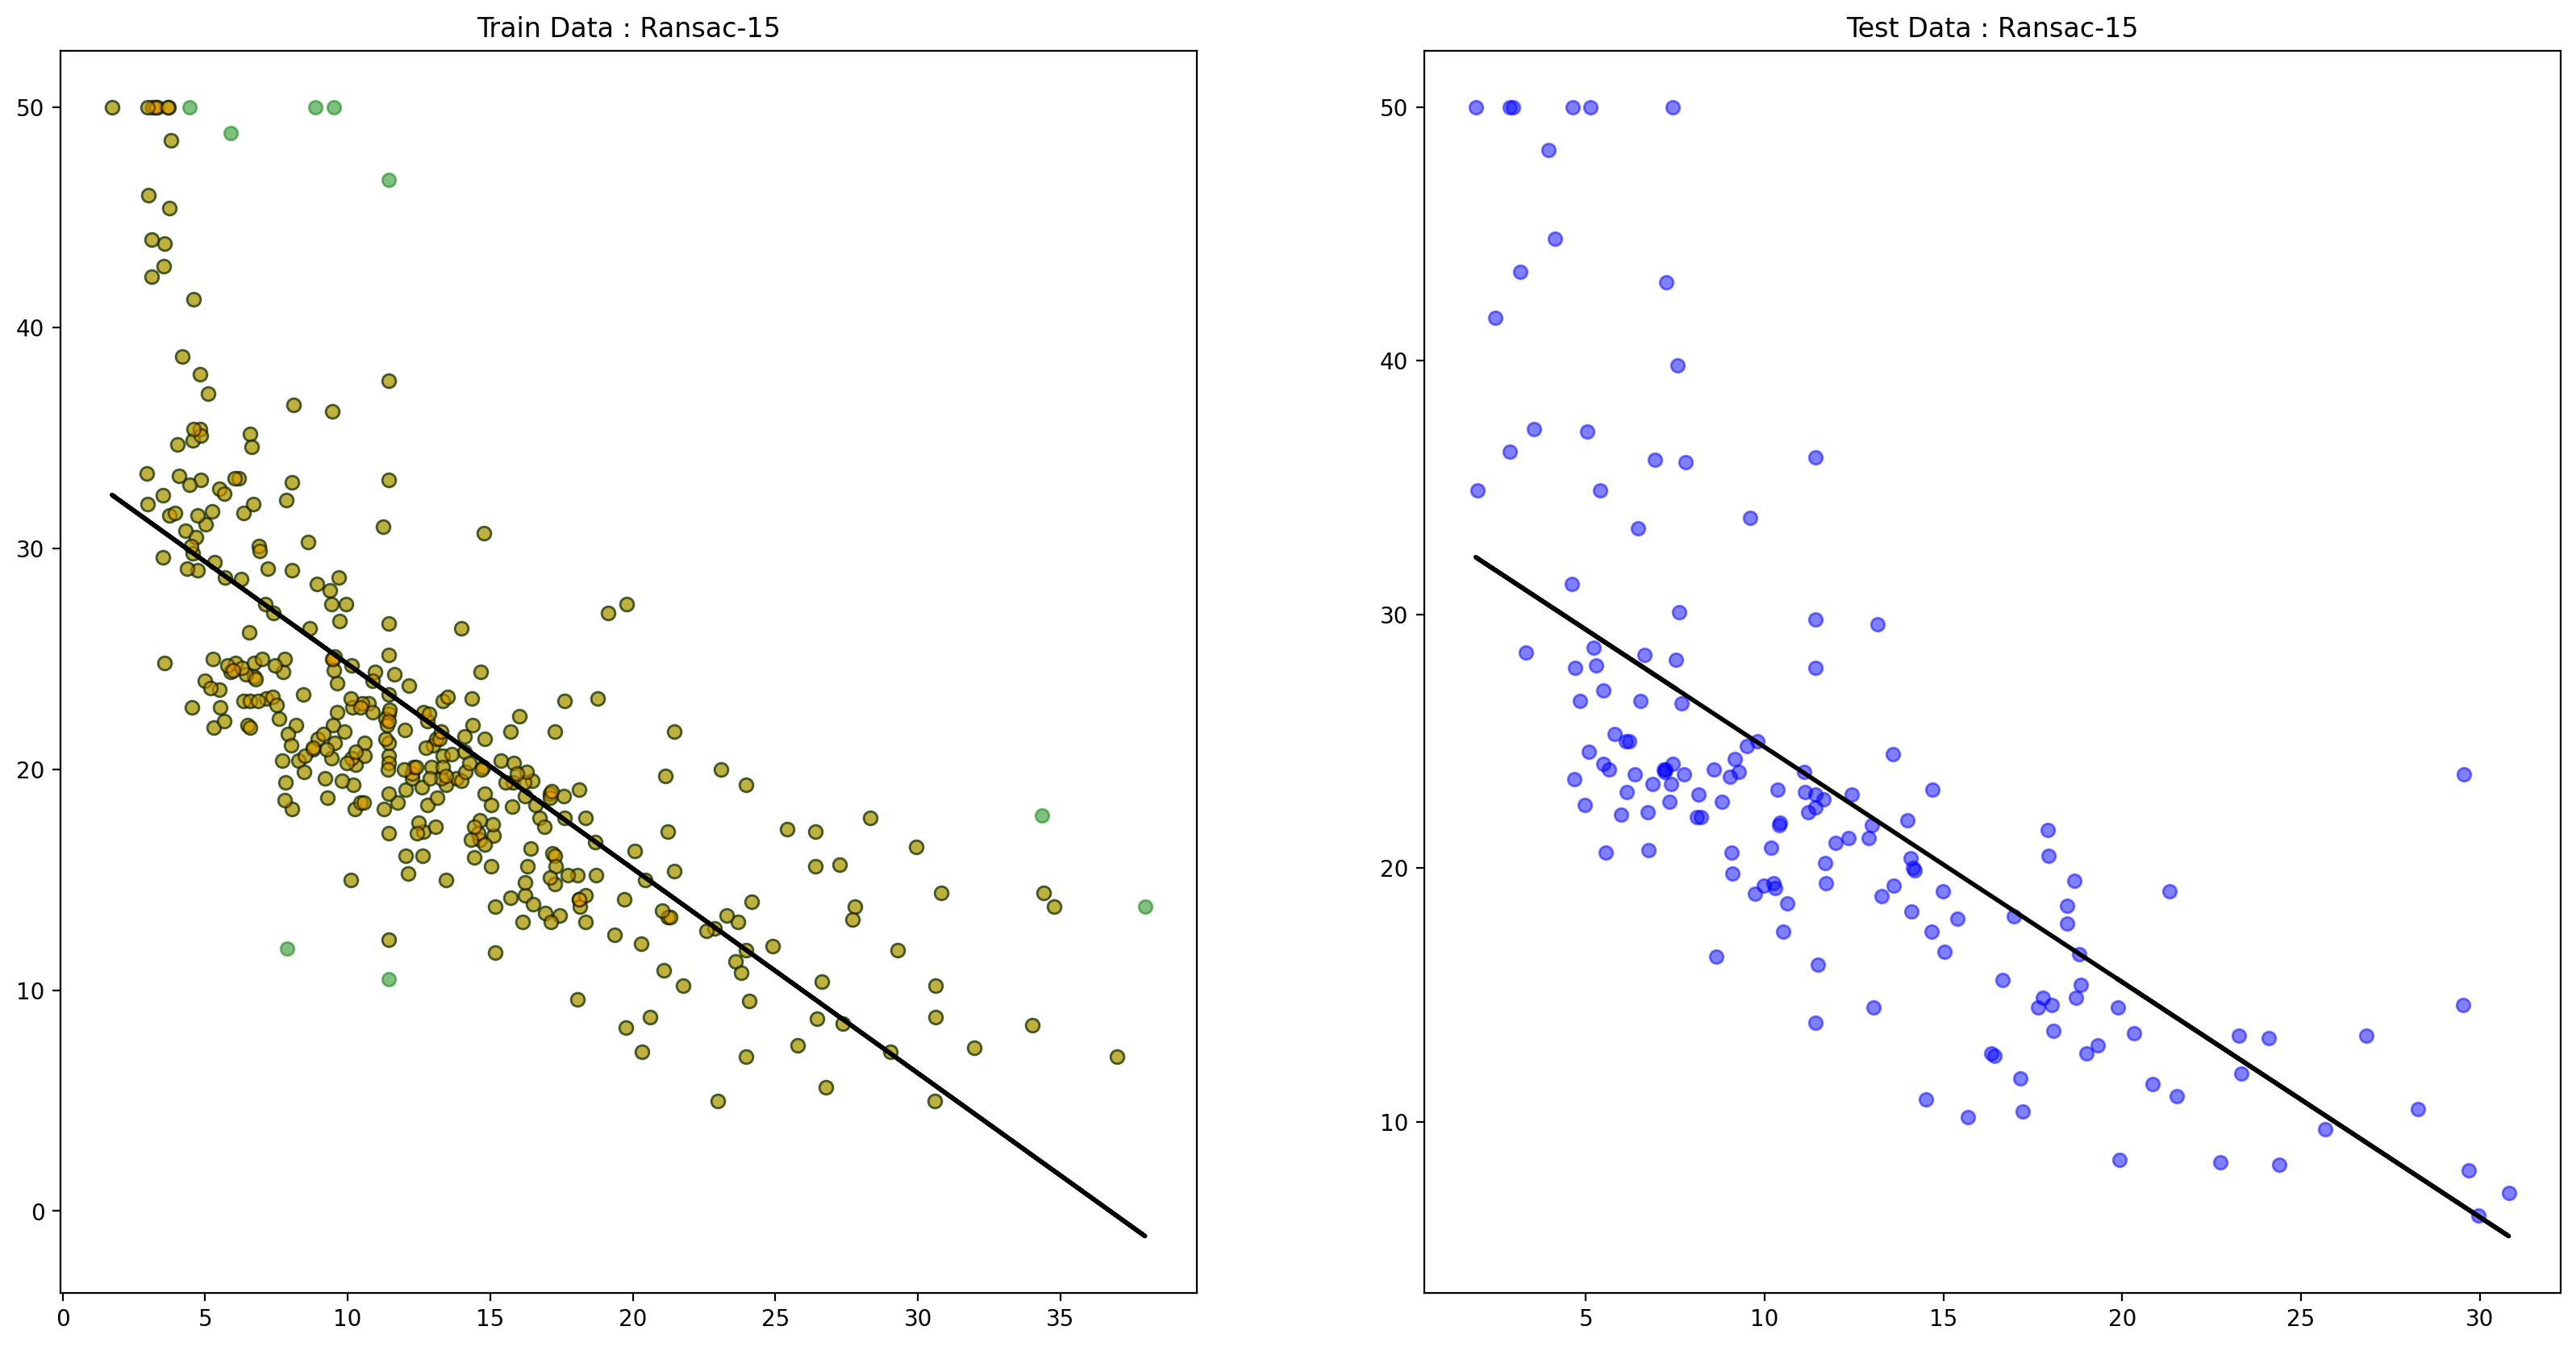

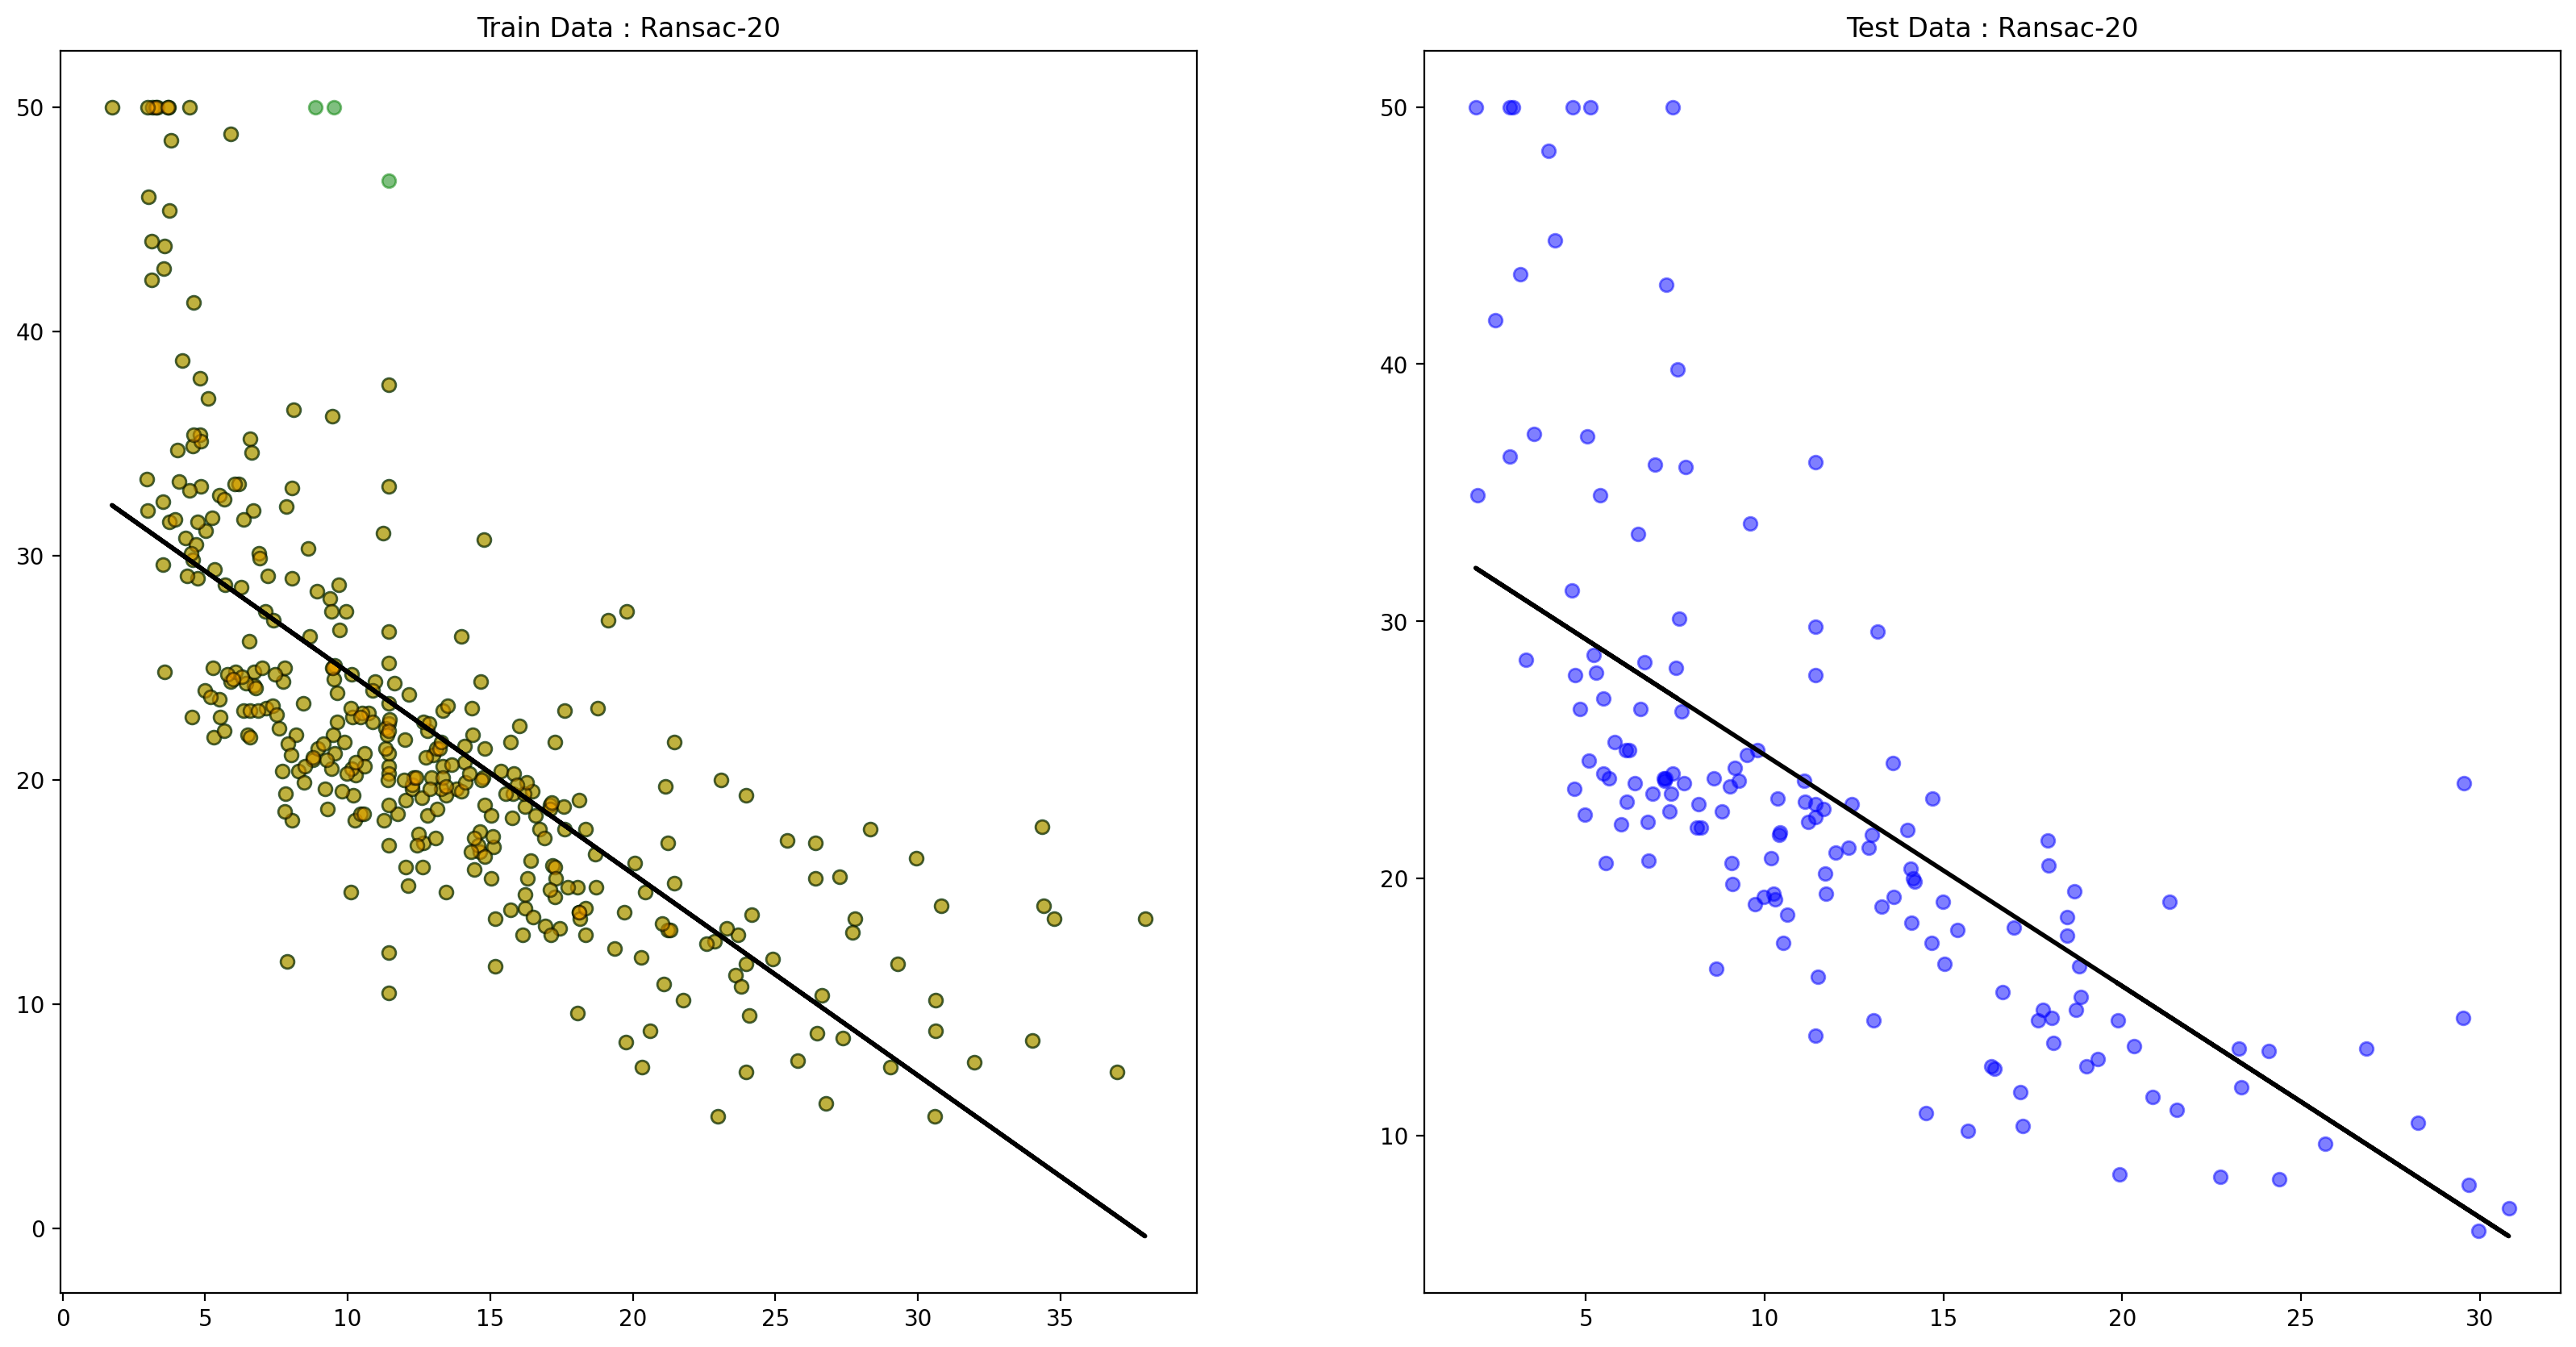

In [171]:
params = [1, 5, 10, 15, 20]
cols = ['model name', 'Coef', 'Intercept', 'MSE Train', 'MSE Test', 'R2 Train', 'R2 Test']

result = pd.DataFrame(columns = cols)

for e in params:
    
    rc = RANSACRegressor(
            LinearRegression(),
            max_trials=100,
            min_samples=50,
            loss = 'absolute_error',
            residual_threshold= e,
            random_state=1
        )
    model_name = f'Ransac-{e}'
    
    collect = train(rc, X_train, y_train, X_test, y_test, model_name, cols)
    df2 = pd.DataFrame({
        'model name' : collect[0],
        'Coef' : collect[1],
        'Intercept' : collect[2],
        'MSE Train' : collect[3],
        'MSE Test' : collect[4],
        'R2 Train' : collect[5],
        'R2 Test' : collect[6],
    })
    result = pd.concat([result, df2], axis = 0, ignore_index=True)
    
result
    